This notebook is modified from the PyTorch transfer learning tutorial. Everything is running on Colab.
To run this notebook, you need to download data from https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification and upload to colab. After unzip the data, create a `data` directory and put `train` and `valid` folder under `data`.

In [1]:
%matplotlib inline
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

In [4]:
!unzip cats.zip

Archive:  cats.zip
  inflating: EfficientNetB0-10-(224 X 224)-100.00.h5  
  inflating: MobileNetV3 small-10-(224 X 224)-95.96.h5  
  inflating: WILDCATS.CSV            
  inflating: test/AFRICAN LEOPARD/1.jpg  
  inflating: test/AFRICAN LEOPARD/2.jpg  
  inflating: test/AFRICAN LEOPARD/3.jpg  
  inflating: test/AFRICAN LEOPARD/4.jpg  
  inflating: test/AFRICAN LEOPARD/5.jpg  
  inflating: test/CARACAL/1.jpg      
  inflating: test/CARACAL/2.jpg      
  inflating: test/CARACAL/3.jpg      
  inflating: test/CARACAL/4.jpg      
  inflating: test/CARACAL/5.jpg      
  inflating: test/CHEETAH/1.jpg      
  inflating: test/CHEETAH/2.jpg      
  inflating: test/CHEETAH/3.jpg      
  inflating: test/CHEETAH/4.jpg      
  inflating: test/CHEETAH/5.jpg      
  inflating: test/CLOUDED LEOPARD/1.jpg  
  inflating: test/CLOUDED LEOPARD/2.jpg  
  inflating: test/CLOUDED LEOPARD/3.jpg  
  inflating: test/CLOUDED LEOPARD/4.jpg  
  inflating: test/CLOUDED LEOPARD/5.jpg  
  inflating: test/JAGUAR/1.jpg 

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


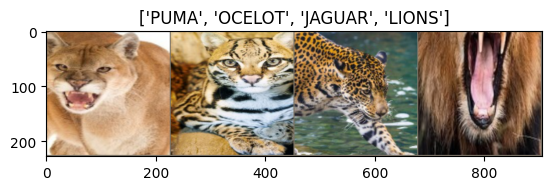

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3523 Acc: 0.5190
valid Loss: 0.6963 Acc: 0.7200

Epoch 1/24
----------
train Loss: 1.0234 Acc: 0.6631
valid Loss: 0.2719 Acc: 0.8600

Epoch 2/24
----------
train Loss: 0.9127 Acc: 0.7080
valid Loss: 0.1795 Acc: 0.9600

Epoch 3/24
----------
train Loss: 0.8028 Acc: 0.7413
valid Loss: 0.2313 Acc: 0.9600

Epoch 4/24
----------
train Loss: 0.7877 Acc: 0.7431
valid Loss: 0.2607 Acc: 0.9400

Epoch 5/24
----------
train Loss: 0.7565 Acc: 0.7550
valid Loss: 0.3944 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.6851 Acc: 0.7841
valid Loss: 0.3572 Acc: 0.9600

Epoch 7/24
----------
train Loss: 0.5021 Acc: 0.8401
valid Loss: 0.1486 Acc: 0.9600

Epoch 8/24
----------
train Loss: 0.5071 Acc: 0.8388
valid Loss: 0.3226 Acc: 0.9400

Epoch 9/24
----------
train Loss: 0.4540 Acc: 0.8551
valid Loss: 0.1282 Acc: 0.9800

Epoch 10/24
----------
train Loss: 0.4454 Acc: 0.8628
valid Loss: 0.2286 Acc: 0.9800

Epoch 11/24
----------
train Loss: 0.4192 Acc: 0.8615
valid Loss

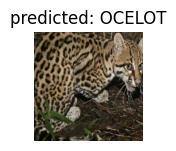

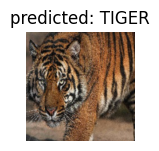

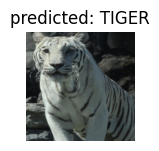

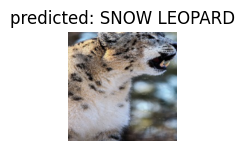

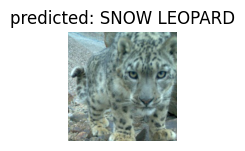

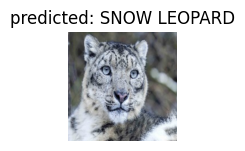

In [9]:
visualize_model(model_ft)

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5003 Acc: 0.4810
valid Loss: 0.7626 Acc: 0.7000

Epoch 1/24
----------
train Loss: 1.1445 Acc: 0.6131
valid Loss: 0.5751 Acc: 0.8200

Epoch 2/24
----------
train Loss: 1.0495 Acc: 0.6511
valid Loss: 0.4982 Acc: 0.8000

Epoch 3/24
----------
train Loss: 1.0720 Acc: 0.6272
valid Loss: 0.4447 Acc: 0.9000

Epoch 4/24
----------
train Loss: 1.0453 Acc: 0.6451
valid Loss: 0.5740 Acc: 0.8000

Epoch 5/24
----------
train Loss: 1.0239 Acc: 0.6614
valid Loss: 0.3809 Acc: 0.8600

Epoch 6/24
----------
train Loss: 1.0039 Acc: 0.6691
valid Loss: 0.4870 Acc: 0.8200

Epoch 7/24
----------
train Loss: 0.8616 Acc: 0.7127
valid Loss: 0.4177 Acc: 0.8800

Epoch 8/24
----------
train Loss: 0.9138 Acc: 0.6926
valid Loss: 0.4209 Acc: 0.8600

Epoch 9/24
----------
train Loss: 0.8612 Acc: 0.6986
valid Loss: 0.5498 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.8179 Acc: 0.7242
valid Loss: 0.4653 Acc: 0.8400

Epoch 11/24
----------
train Loss: 0.8010 Acc: 0.7379
valid Loss

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


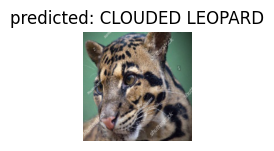

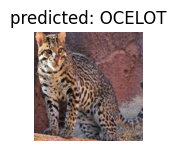

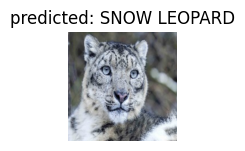

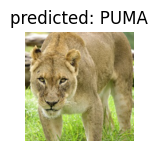

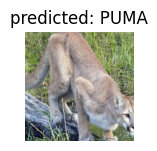

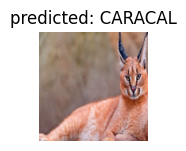

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()